In [ ]:
# !pip install 'gym[box2d]'
# !apt-get install python-opengl -y
# !apt install xvfb -y
# !pip install pyvirtualdisplay
# !pip install https://github.com/pyglet/pyglet/archive/pyglet-1.5-maintenance.zip
# !apt-get install ffmpeg -y
# !pip install torch==1.6

In [1]:
# env.render() gives error in Colab
# below code solves display error
# https://github.com/openai/gym/issues/1898


from pyvirtualdisplay import Display
display = Display(visible=0,size=(600,600))
display.start()

In [2]:
import random
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from maze_env import Maze
from utils import plot_policy, plot_tabular_cost_to_go, test_agent, plot_stats, seed_everything

np.random.seed(45)

## Implement state aggregation

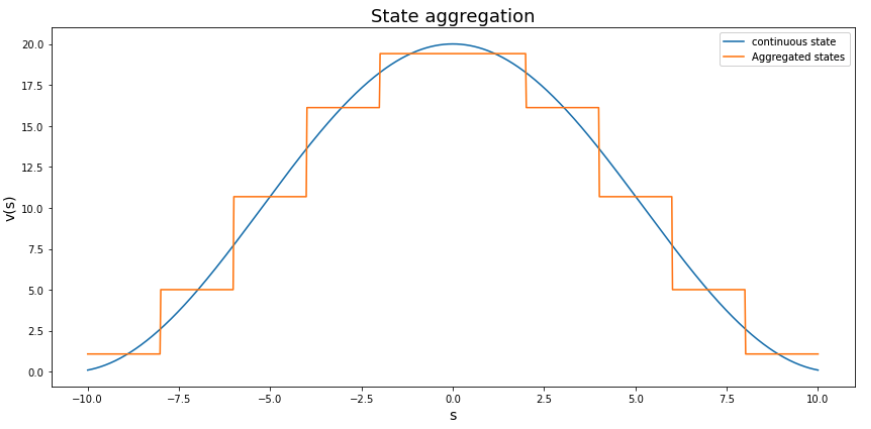

### Create the environment

In [3]:
env = gym.make("MountainCar-v0")
seed_everything(env)

In [11]:
# gives intial postion , velocity of car
env.reset()


array([-0.50313229,  0.        ])

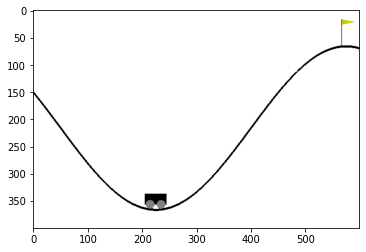

In [5]:
frame = env.render(mode="rgb_array")
plt.imshow(frame)

### Create the state aggregation wrapper

In [6]:
class StateAggregationEnv(gym.ObservationWrapper):

    def __init__(self, env, bins, low, high):
        super().__init__(env)
        
        # low = [-1.2,-0.07] high = [0.6,0.07] bins = [20,20]
        self.buckets = [np.linspace(l,h,b-1) for l,h,b in zip(low,high,bins)]

        # [20,20] -> 400
        self.observation_space = gym.spaces.MultiDiscrete(nvec=bins.tolist())

    
    def observation(self, state):
        # [-1.2, 0] -> [4,3]
        indices = tuple(np.digitize(cont,buck) for cont, buck in zip(state, self.buckets))
        return indices

In [7]:
bins = np.array([20,20])
low = env.observation_space.low
high = env.observation_space.high
saenv = StateAggregationEnv(env, bins, low, high)

In [8]:
saenv.buckets

[array([-1.20000005, -1.10000004, -1.00000004, -0.90000004, -0.80000003,
        -0.70000003, -0.60000002, -0.50000002, -0.40000002, -0.30000001,
        -0.20000001, -0.1       ,  0.        ,  0.1       ,  0.20000001,
         0.30000001,  0.40000002,  0.50000002,  0.60000002]),
 array([-0.07      , -0.06222222, -0.05444444, -0.04666667, -0.03888889,
        -0.03111111, -0.02333333, -0.01555556, -0.00777778,  0.        ,
         0.00777778,  0.01555556,  0.02333333,  0.03111111,  0.03888889,
         0.04666667,  0.05444444,  0.06222222,  0.07      ])]

### Compare the original environment to the one with aggregated states

In [9]:
print(f"Modified observation space: {saenv.observation_space}, \n\
Sample state: {saenv.observation_space.sample()}")

Modified observation space: MultiDiscrete([20 20]), 
Sample state: [14 15]


In [10]:
print(f"Original observation space: {env.observation_space}, \n\
Sample state: {env.observation_space.sample()}")

Original observation space: Box(-1.2000000476837158, 0.6000000238418579, (2,), float32), 
Sample state: [-0.52654195 -0.0021926 ]


### Create the $Q(s,a)$ value table

In [12]:
# 20 x 20 state space with 3 possible choice - Forward, Back, Still
action_values = np.zeros((20,20, 3))

### Create the $\epsilon$-greedy policy: $\pi(s)$

In [13]:
def policy(state, epsilon=0.):
    if np.random.random() < epsilon:
        return np.random.randint(3)
    else:
        av = action_values[state]
        return np.random.choice(np.flatnonzero(av == av.max()))

### Test the SARSA algorithm on the modified environment

In [14]:
def sarsa(action_values, policy, episodes, alpha=0.1, gamma=0.99, epsilon=0.2):
    stats = {'Returns': []}
    for episode in tqdm(range(1, episodes + 1)):
        state = saenv.reset()
        action = policy(state, epsilon)
        done = False
        ep_return = 0
        while not done:
            next_state, reward, done, _ = saenv.step(action)
            next_action = policy(next_state, epsilon)
            
            qsa = action_values[state][action]
            next_qsa = action_values[next_state][next_action]
            action_values[state][action] = qsa + alpha * (reward + gamma * next_qsa - qsa)
            state = next_state
            action = next_action
            ep_return += reward
        stats['Returns'].append(ep_return)
    return stats

In [15]:
stats = sarsa(action_values, policy, 20000, alpha=0.1, epsilon=0.)

100%|██████████| 20000/20000 [06:27<00:00, 51.59it/s]


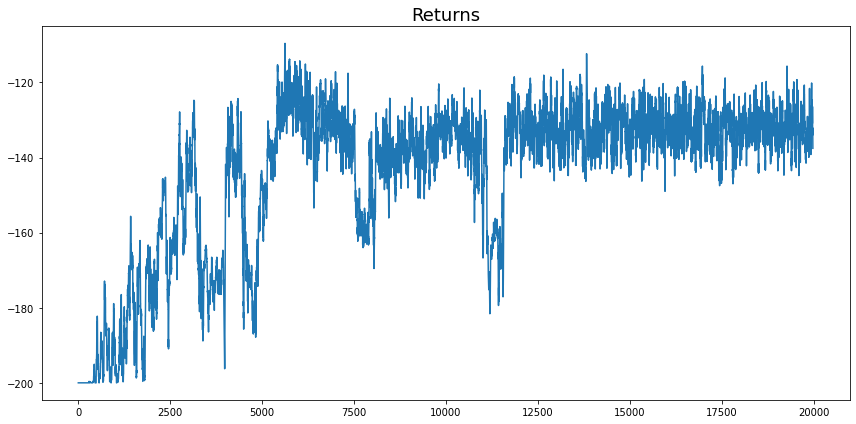

In [16]:
plot_stats(stats)

### Plot the learned policy: $\pi(s)$

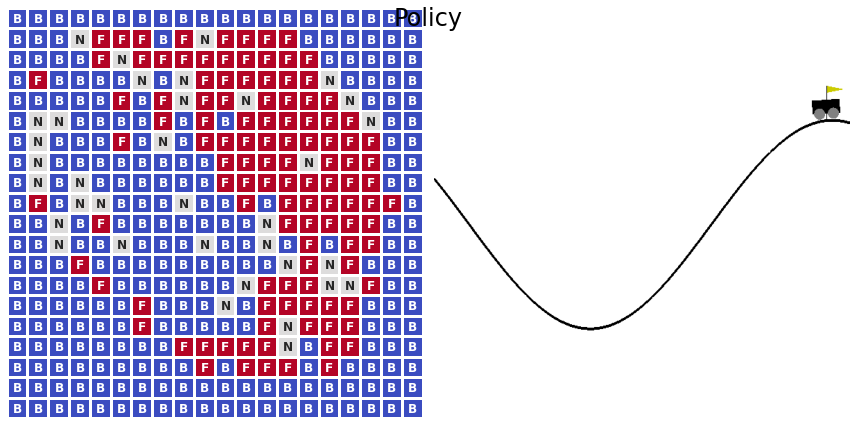

In [17]:
plot_policy(action_values, env.render(mode='rgb_array'), \
            action_meanings={0: 'B', 1: 'N', 2: 'F'})

### Plot the cost to go: $ - \max_a \hat q(s,a|\theta)$

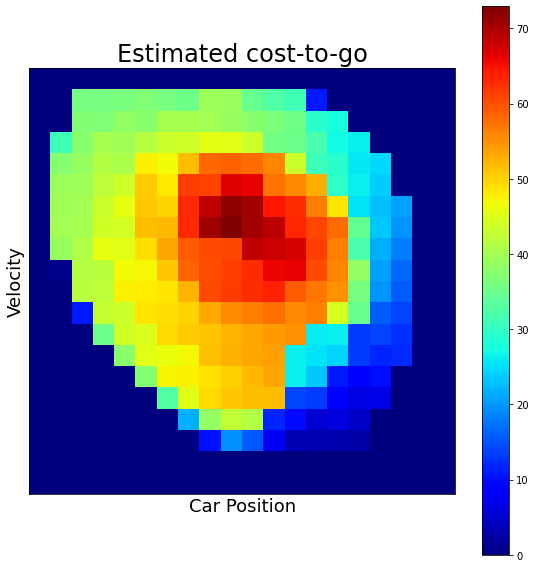

In [18]:
plot_tabular_cost_to_go(action_values, xlabel="Car Position", ylabel="Velocity")

### Test the resulting policy

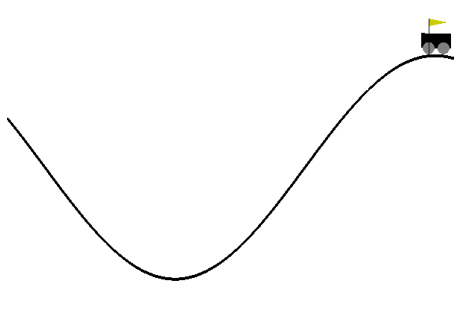

In [19]:
test_agent(saenv, policy, 2)

## Implement Tile Coding

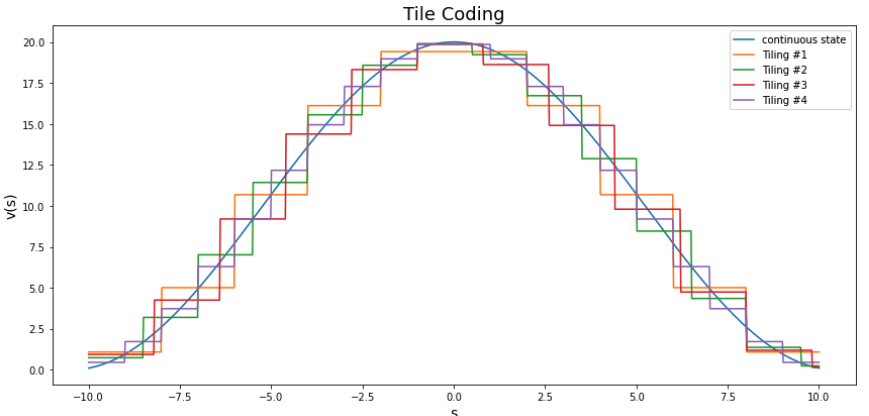

### Create the environment

In [20]:
env = gym.make("MountainCar-v0")
seed_everything(env)

### Create the Tile Coding wrapper

In [32]:
class TileCodingEnv(gym.ObservationWrapper):

    # intialize
    def __init__(self, env, bins, low, high, n):
        super().__init__(env)
        self.tilings = self._create_tilings(bins, high, low, n)
        self.observation_space = gym.spaces.MultiDiscrete(nvec=bins.tolist() * n )

    # observation
    def observation(self, state):
        # [(5,4),(5,3)....] state space from each tiling
        indices = []
        for t in self.tilings:
            tiling_indices = tuple(np.digitize(i,b) for i, b in zip(state,t))
            indices.append(tiling_indices)
        return indices


    # crate tilings
    def _create_tilings(self, bins, high, low, n):
        displacement_vector = np.arange(1, 2*len(bins), 2)
        tilings = []

        for i in range(1,n+1):
            low_i = low - random.random() * 0.2 * low
            high_i = high + random.random() * 0.2 * high
            segment_sizes = (high_i - low_i)/bins
            displacements = displacement_vector * i % n
            displacements = displacements * (segment_sizes / n)
            low_i += displacements
            high_i += displacements
            buckets_i = [np.linspace(l, h, b-1) for l, h, b in zip(low_i, high_i, bins)]
            tilings.append(buckets_i)
        return tilings

In [33]:
tilings = 4 
bins = np.array([20,20])
low = env.observation_space.low
high = env.observation_space.high
tcenv = TileCodingEnv(env, bins=bins, low=low, high=high, n=tilings)

### Compare the original environment to the one with aggregated states

In [34]:
print(f"Modified observation space: {tcenv.observation_space}, \n\
Sample state: {tcenv.reset()}")

Modified observation space: MultiDiscrete([20 20 20 20 20 20 20 20]), 
Sample state: [(6, 8), (6, 8), (7, 9), (6, 9)]


In [35]:
print(f"Original observation space: {env.observation_space}, \n\
Sample state: {env.reset()}")

Original observation space: Box(-1.2000000476837158, 0.6000000238418579, (2,), float32), 
Sample state: [-0.48878117  0.        ]


### Create the $Q(s,a)$ value table

In [36]:
action_values = np.zeros((4, 20, 20, 3))

### Create the $\epsilon$-greedy policy: $\pi(s)$

In [37]:
def policy(state, epsilon=0.):
    if np.random.random() < epsilon:
        return np.random.randint(3)
    else:
        av_list = []
        for i, idx in enumerate(state):
            av = action_values[i][idx]
            av_list.append(av)
            
        # [[1,2,3], [4,5,6]] -> [2.5, 3.5, 4.5]
        av = np.mean(av_list, axis=0)
        return np.random.choice(np.flatnonzero(av==av.max()))

### Test the SARSA algorithm on the modified environment

In [38]:
def sarsa(action_values, policy, episodes, alpha=0.1, gamma=0.99, epsilon=0.2):
    stats = {'Returns': []}
    for episode in tqdm(range(1, episodes + 1)):
        state = tcenv.reset()
        action = policy(state, epsilon)
        done = False
        ep_return = 0
        while not done:
            next_state, reward, done, _ = tcenv.step(action)
            next_action = policy(next_state, epsilon)
            
            for i, (idx, next_idx) in enumerate(zip(state, next_state)):
                qsa = action_values[i][idx][action]
                next_qsa = action_values[i][next_idx][next_action]
                action_values[i][idx][action] = qsa + alpha * (reward + gamma * next_qsa - qsa)
            
            state = next_state
            action = next_action
            ep_return += reward
        stats['Returns'].append(ep_return)
    return stats

In [39]:
stats = sarsa(action_values, policy, 20000, alpha=0.1, epsilon=0.)

100%|██████████| 20000/20000 [11:07<00:00, 29.98it/s]


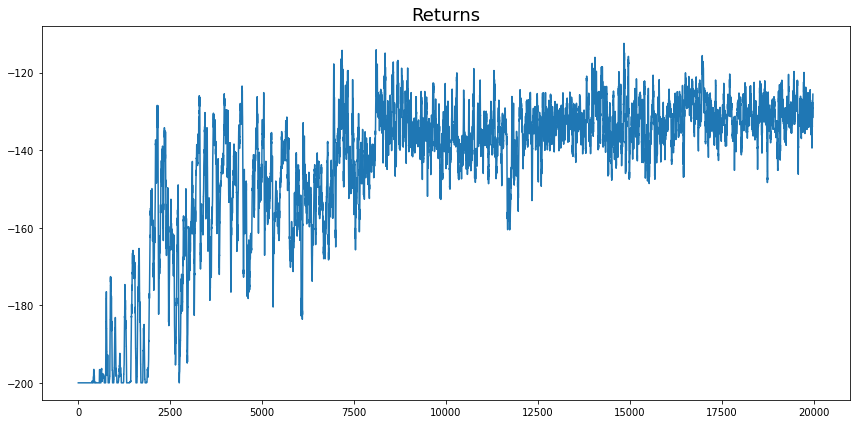

In [40]:
plot_stats(stats)

### Plot the learned policy: $\pi(s)$

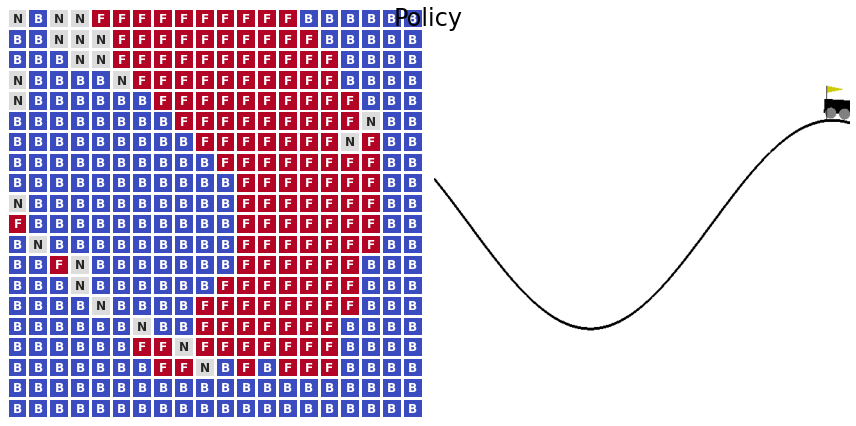

In [41]:
plot_policy(action_values.mean(axis=0), env.render(mode='rgb_array'), \
            action_meanings={0: 'B', 1: 'N', 2: 'F'})

### Plot the cost to go: $ - \max_a \hat q(s,a|\theta)$

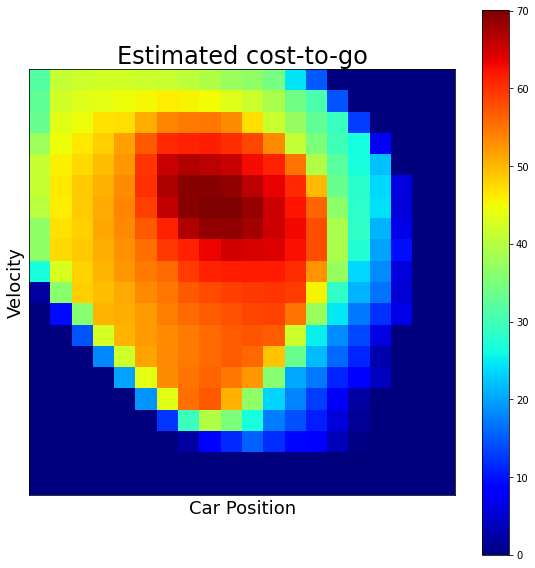

In [42]:
plot_tabular_cost_to_go(action_values.mean(axis=0), \
                        xlabel="Car Position", ylabel="Velocity")

### Test the resulting policy

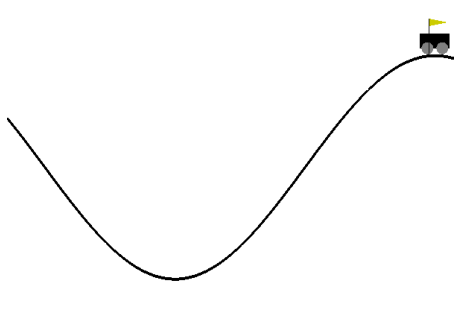

In [43]:
test_agent(tcenv, policy, 2)

## Resources

[[1] Reinforcement Learning: An Introduction. Section 9.5.4: Tile Coding](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)